In [2]:
import numpy as np
import multiprocessing #多线程处理
import cv2
import matplotlib.pyplot as plt #绘图


import rosbag #处理rosbag
from cv_bridge import CvBridge

import sys
sys.path.append('/home/gwp/rpg_vid2e/rosbag_reading')  # 替换为实际的路径(注意如果修改了py文件的代码需要重新restart kernel)
from utils.bag_utils import read_H_W_from_bag, read_tss_us_from_rosbag, read_images_from_rosbag, read_evs_from_rosbag, read_evs_from_rosbag_intimestamp,read_rgb_images_from_rosbag
print("import ultils to process the rosbag")

import ultils to process the rosbag


In [3]:
rosbag_file="../example/HKU-dataset/hku6.bag"
# 从rosbag文件中读取数据
bag_data = rosbag.Bag(rosbag_file, "r")

topics = list(bag_data.get_type_and_topic_info()[1].keys())
print("all the topic name in this rosbag",topics)

all the topic name in this rosbag ['/DAVIS346/events', '/DAVIS346/image', '/DAVIS346/imu', '/camera/color/image_raw', '/camera/depth/image_rect_raw', '/camera/imu', '/camera/infra1/image_rect_raw', '/camera/infra2/image_rect_raw']


In [4]:
image_topic_name='/DAVIS346/image';

# 读取图像的长与宽
H, W = read_H_W_from_bag(bag_data, image_topic_name)
# 读取图像数据
# imgs = read_images_from_rosbag(bag_data, image_topic_name, H=H, W=W) #注意这是对于灰度图的读取
imgs = read_rgb_images_from_rosbag(bag_data, image_topic_name, H=H, W=W) #读取彩色图像


Read H, W from bag: 260, 346


100%|██████████| 3049/3049 [03:40<00:00, 13.83it/s]


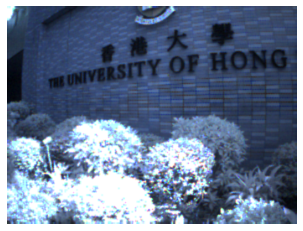

In [104]:
#  获取一组图片
image_index=1537;
index_range=2;
image_set=imgs[image_index:image_index+index_range]#提取index_range张图片

# 显示这张图片
image=image_set[1];
# image_color = image[:, :, None].repeat(3, axis=2) # 把real event画在image上, (H,W) -> (H,W,1) -> (H,W,3)
image_color = image
plt.imshow(image_color)
plt.axis('off') #不显示坐标
plt.show()

# 读取图像的时间戳
timestamp_imgs_us = read_tss_us_from_rosbag(bag_data, image_topic_name)
#提取上面选择的10张图片对应的时间戳
timestamp_imgs_us_set=timestamp_imgs_us[image_index:image_index+index_range]
assert len(timestamp_imgs_us_set) == len(image_set)

timestamp_us_0=timestamp_imgs_us_set[0];#第一张图片的时间戳
timestamp_us_1=timestamp_imgs_us_set[-1];#最后一张图片的时间戳

In [105]:
# 读取事件数据
event_topic_name='/DAVIS346/events'
all_events = read_evs_from_rosbag_intimestamp(bag_data, event_topic_name, timestamp_us_0, timestamp_us_1)

#  转换一下存储格式
real_events = {
    'x': np.array([event['x'] for event in all_events]),
    'y': np.array([event['y'] for event in all_events]),
    't': np.array([event['t'] for event in all_events]),
    'p': np.array([event['p'] for event in all_events])
}

print("the number of real event",len(real_events['x']))

Start reading evs from /DAVIS346/events,事件的极性为1和-1


  0%|          | 2/6002 [00:00<40:06,  2.49it/s]

the number of real event 102258


the number of real event stream 32010


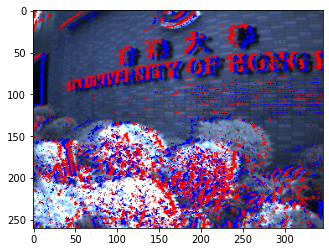

In [106]:
# 提取在这个时间段内的事件
mask = (real_events['t'] >= timestamp_imgs_us_set[0]) & (real_events['t'] < timestamp_imgs_us_set[1])
real_event_stream = {k: v[mask] for k, v in real_events.items()}
print("the number of real event stream",len(real_event_stream['x']))

image_color = image
xytp = np.stack([real_event_stream['x'],
                 real_event_stream['y'], 
                 real_event_stream['t'], 
                 real_event_stream['p']], -1).astype(np.int64)  # (N,4)
neg_mask = (xytp[:, -1] == -1)
pos_mask = (xytp[:, -1] == 1)

# 这样做法避免了叠加产生粉红色
image_color[xytp[neg_mask][:, 1], xytp[neg_mask][:, 0]] = np.array([[0., 0., 255.,]]) #将-事件的位置设置为blue
image_color[xytp[pos_mask][:, 1], xytp[pos_mask][:, 0]] = np.array([[255., 0., 0.,]]) #将+事件的位置设置为red

plt.imshow(image_color)
plt.show()